In [ ]:
! pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("lightblue/multilingual_prompts_100_sample_evaled", split="train")

Generating train split:   0%|          | 0/2996 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted', 'lang_detect_result', 'first_exchange_len_tokens', '__index_level_1__', 'llm_responses', 'model_evals'],
    num_rows: 2996
})

# Parse rankings from GPT-4 output

In [ ]:
import json
import numpy as np

def get_model_from_id(model_id_list, model_id):
    model_id = model_id.strip()
    model_id_items = [(i, x) for i, x in model_id_list if i == model_id]
    assert len(model_id_items) == 1, f"There should be 1 model with an A-G id, but you searched for {model_id} which has {len(model_id_items)} matches"
    return model_id_items[0]

def get_llm_ranking(eval_response, model_id_list):
    ranking_split_lost = eval_response.split("<<<RANKING>>>")

    if len(ranking_split_lost) < 2:
        # If the eval output does not contain the designated <<<RANKING>>> string, we disregard that evaluation.
        return None

    ranking_only = ranking_split_lost[-1].strip()

    rankings = {}
    ranked_ids = set()
    for i, id_ranking in enumerate(ranking_only.split(">")):
        rankings[str(i)] = []
        for single_id in id_ranking.split("="):
            # If the eval code ranks the same item twice in the same ranking, we return None and scrap the ranking
            if single_id in ranked_ids:
                return None
            ranked_ids = ranked_ids.union(set([single_id]))
            rankings[str(i)].append(get_model_from_id(model_id_list, single_id))
    return rankings

flatten_list = lambda l: [x for ll in l for x in ll]

def calculate_normalized_ranking(model_names, ranking):

    model_rank_numbers = [np.nan] * len(model_names)

    current_rank = 1
    for rank_int in sorted([int(x) for x in ranking.keys()]):
        current_rank_models = [x[1] for x in ranking[str(rank_int)]]

        for model_name in current_rank_models:
            model_rank_numbers[model_names.index(model_name)] = current_rank

        current_rank += len(current_rank_models)

    return np.array(model_rank_numbers)

def process_eval(row):
    model_names = sorted(row["llm_responses"].keys())

    evaluation_rankings = []
    for eval_dict in row["model_evals"]:
        if eval_dict["eval_response"] is None:
            # If the eval code bugged out and we got a None value, we skip that ranking. Most likely caused by too many requests.
            continue

        ranking = get_llm_ranking(
            eval_dict["eval_response"],
            eval_dict["model_id_list"]
        )

        if ranking is None:
            continue

        normalized_ranking = calculate_normalized_ranking(
            model_names,
            ranking
        )

        evaluation_rankings.append({
            "ranking": ranking,
            "normalized_ranking": normalized_ranking,
        })

    return {
        "rankings": evaluation_rankings,
    }

In [ ]:
dataset = dataset.map(lambda x: process_eval(x))

Map:   0%|          | 0/2996 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
pd.Series([len(x["rankings"]) for x in dataset]).value_counts()

5    2938
4      50
3       5
2       2
1       1
Name: count, dtype: int64

In [ ]:
dataset = dataset.filter(lambda x: all([y["finish_reason"] == "stop" for y in x["llm_responses"].values()]))

Filter:   0%|          | 0/2996 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.filter(lambda x: len(x["rankings"]) == 5)

Filter:   0%|          | 0/2762 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted', 'lang_detect_result', 'first_exchange_len_tokens', '__index_level_1__', 'llm_responses', 'model_evals', 'rankings'],
    num_rows: 2714
})

# Calculate Kendall's W from rankings

In [ ]:
import numpy as np

def calculate_kendall_w_and_chisq(rankings):

    # Number of judges (k) and number of items (n)
    k = rankings.shape[1]
    n = rankings.shape[0]

    # Calculate total ranks for each item
    total_ranks = np.sum(rankings, axis=1)

    # Calculate sum of squared differences from the mean (SS Rank Totals)
    mean_total_ranks = np.mean(total_ranks)
    ss_rank_totals = np.sum((total_ranks - mean_total_ranks) ** 2)

    # Calculate Kendall's W using the simplified formula
    w = (12 * ss_rank_totals) / (k**2 * (n**3 - n))

    # Calculate Chi-square statistic
    chi_square = k * (n - 1) * w

    return w, chi_square

def add_kendall_w_and_chisq(row, lim=None):
    rankings = np.array([x["normalized_ranking"] for x in row["rankings"]])
    rankings = rankings.T if lim is None else rankings.T[:, :lim]
    w, chi_square = calculate_kendall_w_and_chisq(rankings)
    return {f"kendall_w{lim if lim is not None else ''}": w, f"chi_square{lim if lim is not None else ''}": chi_square}

### Quick W analysis

Analyze how the W generated from 2 rankings, 3 rankings, 4 rankings compares to the W generated from all 5 rankings.

We see that the W scores get more correlated (obviously) as the number of rankings increases.

<Axes: xlabel='kendall_w5', ylabel='kendall_w4'>

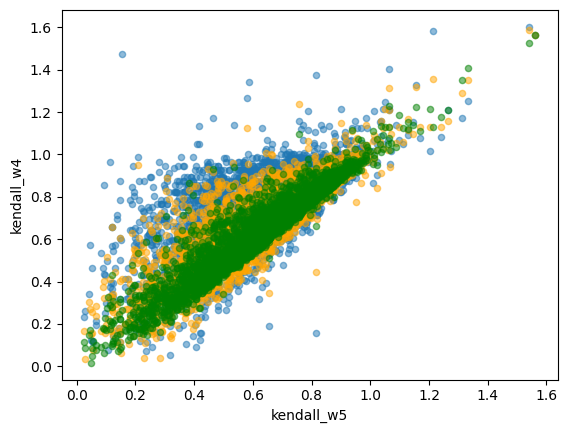

In [ ]:
dataset = dataset.map(lambda x: add_kendall_w_and_chisq(x))
dataset = dataset.map(lambda x: add_kendall_w_and_chisq(x, lim=2))
dataset = dataset.map(lambda x: add_kendall_w_and_chisq(x, lim=3))
dataset = dataset.map(lambda x: add_kendall_w_and_chisq(x, lim=4))
dataset = dataset.map(lambda x: add_kendall_w_and_chisq(x, lim=5))

w_df = dataset.select_columns(['kendall_w2', 'kendall_w3', 'kendall_w4', 'kendall_w5']).to_pandas()

ax = w_df.plot.scatter(x="kendall_w5", y="kendall_w2", alpha=0.5)
w_df.plot.scatter(x="kendall_w5", y="kendall_w3", ax=ax, color="orange", alpha=0.5)
w_df.plot.scatter(x="kendall_w5", y="kendall_w4", ax=ax, color="green", alpha=0.5)

# Generate Borda counts

In [ ]:
import itertools
import collections

flatten_list = lambda l: [x for ll in l if isinstance(ll, list) for x in ll]

def borda(ballot_dict):
    n = len(flatten_list(ballot_dict.values()))

    score = itertools.count(n, step = -1)
    result = {}
    ranking_levels = sorted([int(i) for i in ballot_dict.keys()])
    for ranking_level in ranking_levels:
        ranking_preferences = ballot_dict[str(ranking_level)]
        if ranking_preferences is None:
            continue

        rank_level_model_names = [x[1] for x in ranking_preferences]

        s = sum(next(score) for item in rank_level_model_names)/float(len(rank_level_model_names))
        for pref in rank_level_model_names:
            result[pref] = s
    return result

def tally(row):
    ballots = [x["ranking"] for x in row["rankings"]]
    result = collections.defaultdict(int)
    for ballot in ballots:
        for pref, score in borda(ballot).items():
            result[pref]+=score
    result = dict(result)
    return {"borda_ranking": result}

In [ ]:
dataset = dataset.map(lambda x: tally(x))

Map:   0%|          | 0/2714 [00:00<?, ? examples/s]

In [ ]:
df = dataset.to_pandas()

In [ ]:
df["max_borda"] = df["borda_ranking"].apply(lambda x: max(x.values()))
df["min_borda"] = df["borda_ranking"].apply(lambda x: min(x.values()))
df["borda_diff"] = df["max_borda"] - df["min_borda"]

We view the correlation between Kendall's W and the difference between the top and bottom Borda score

<Axes: xlabel='borda_diff', ylabel='kendall_w'>

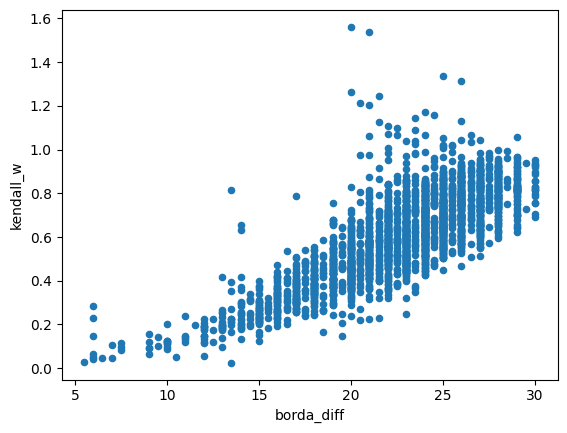

In [ ]:
df[["kendall_w", "borda_diff"]].plot.scatter(x="borda_diff", y="kendall_w")

In [ ]:
import pandas as pd
pd.DataFrame(df["borda_ranking"].values.tolist()).mean().sort_values()

peter-gpt-35-turbo                 15.909359
Nexusflow/Starling-LM-7B-beta      16.565217
Qwen/Qwen1.5-32B-Chat              18.165623
CohereForAI/c4ai-command-r-v01     20.468681
Qwen/Qwen1.5-72B-Chat              20.507553
CohereForAI/c4ai-command-r-plus    21.537951
gpt-4-0125-preview                 26.783714
dtype: float64

Distribution of Borda count scores for each model

array([[<Axes: title={'center': 'CohereForAI/c4ai-command-r-plus'}>,
        <Axes: title={'center': 'CohereForAI/c4ai-command-r-v01'}>,
        <Axes: title={'center': 'Nexusflow/Starling-LM-7B-beta'}>],
       [<Axes: title={'center': 'Qwen/Qwen1.5-32B-Chat'}>,
        <Axes: title={'center': 'Qwen/Qwen1.5-72B-Chat'}>,
        <Axes: title={'center': 'gpt-4-0125-preview'}>],
       [<Axes: title={'center': 'peter-gpt-35-turbo'}>, <Axes: >,
        <Axes: >]], dtype=object)

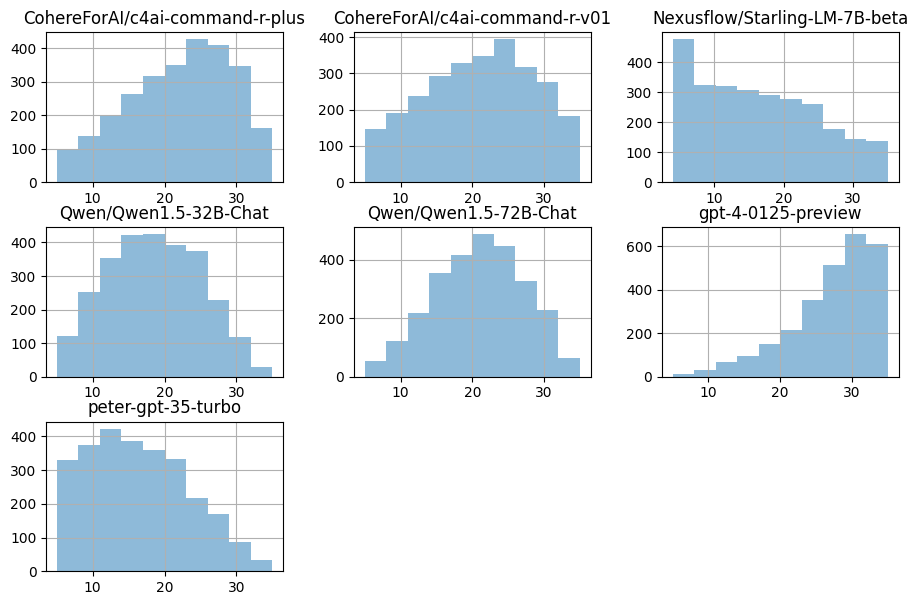

In [ ]:
pd.DataFrame(df["borda_ranking"].values.tolist()).hist(alpha=0.5, figsize=(11,7))

Number of times this model was chosen as the negative response

<Axes: xlabel='borda_ranking'>

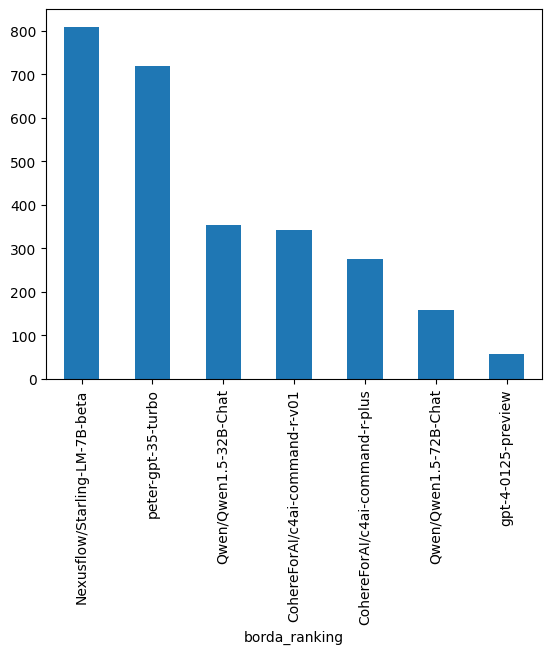

In [ ]:
df["borda_ranking"].apply(lambda x: sorted(x.items(), key=lambda y: y[1])).str[0].str[0].value_counts().plot.bar()

Number of times this model was chosen as the positive response

<Axes: xlabel='borda_ranking'>

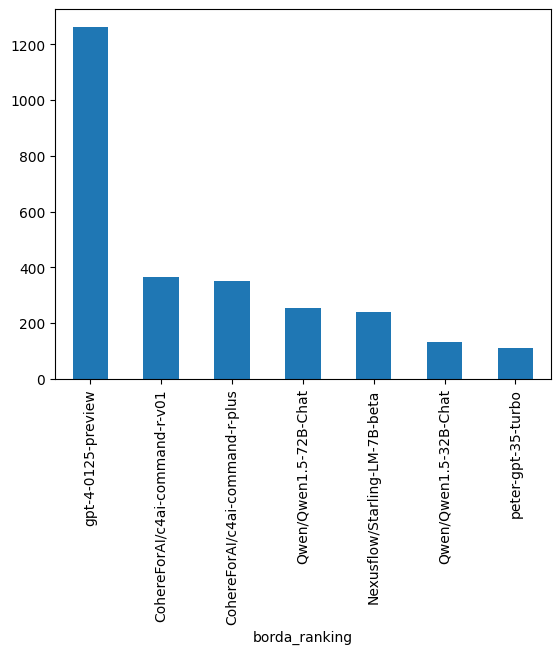

In [ ]:
df["borda_ranking"].apply(lambda x: sorted(x.items(), key=lambda y: y[1])).str[-1].str[0].value_counts().plot.bar()

Distribution of W over the whole dataset

<Axes: >

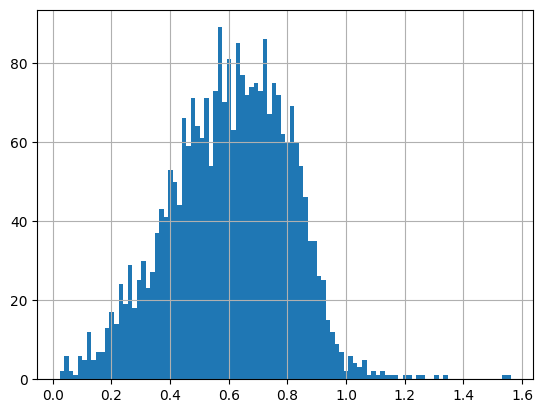

In [ ]:
df["kendall_w"].hist(bins=100)

In [ ]:
df["kendall_w"].median()

0.6142857142857143

One concern I had was whether less popular languages (e.g. Uyghur) would have less consistency in rankings because the LLM would be worse at those languages. However, it seems like there is a similar spread of consistency across all languages.

<Axes: xlabel='num_examples', ylabel='avg_kendall'>

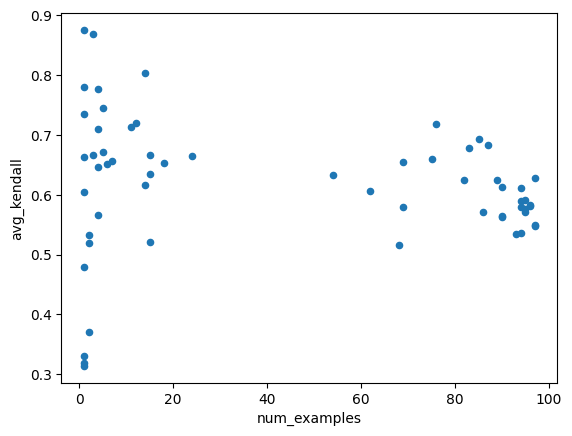

In [ ]:
pd.DataFrame({
    "avg_kendall": df.groupby("language")["kendall_w"].mean(),
    "num_examples": df.groupby("language")["kendall_w"].count()
    }).plot.scatter(x="num_examples", y="avg_kendall")

# Make ORPO datasets

In [ ]:
def prepare_prompt(row):
    return {"prompt": row["conversation"][0]["content"]}

In [ ]:
import random

def get_top_bottom_ranked_models(borda_ranking):
    # We make sure that we randomly shuffle before sorting so that we do not prefer a model based on alphabetical order
    randomly_shuffled_rankings = sorted(borda_ranking.items(), key=lambda x: random.random())
    sorted_rankings = sorted(randomly_shuffled_rankings, key=lambda x: x[1])
    top_rank_model = sorted_rankings[-1][0]
    bottom_rank_model = sorted_rankings[0][0]
    return top_rank_model, bottom_rank_model

In [ ]:
def create_conversation(row, model_name):
    return [
        {"content": row["conversation"][0]["content"], "role": "user"},
        {"content": row["llm_responses"][model_name]["content"], "role": "assistant"},
    ]

In [ ]:
def create_best_worst_cols(row):
    top_rank_model, bottom_rank_model = get_top_bottom_ranked_models(row["borda_ranking"])
    return {
        "prompt": row["conversation"][0]["content"],
        "chosen": create_conversation(row, top_rank_model),
        "rejected": create_conversation(row, bottom_rank_model),
        }

In [ ]:
import copy

## Top vs Bottom Borda all rankings dataset

In [ ]:
import copy

borda_dataset = copy.deepcopy(dataset)

In [ ]:
borda_dataset = borda_dataset.map(create_best_worst_cols)

borda_dataset.select_columns(["prompt", "chosen", "rejected"]).push_to_hub("lightblue/mitsu_full_borda", private=True)

## Top vs Bottom Borda from most consistent 50% dataset

In [ ]:
tophalf_dataset = copy.deepcopy(dataset)

In [ ]:
median_w = df["kendall_w"].median()

In [ ]:
tophalf_dataset = tophalf_dataset.filter(lambda x: x["kendall_w"] >= median_w)

Filter:   0%|          | 0/2714 [00:00<?, ? examples/s]

In [ ]:
tophalf_dataset = tophalf_dataset.map(create_best_worst_cols)

tophalf_dataset.select_columns(["prompt", "chosen", "rejected"]).push_to_hub("lightblue/mitsu_tophalf_borda", private=True)

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/606 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/lightblue/mitsu_tophalf_borda/commit/c54a6f1c5ae111b83a6fda64cef2759d49d812f6', commit_message='Upload dataset', commit_description='', oid='c54a6f1c5ae111b83a6fda64cef2759d49d812f6', pr_url=None, pr_revision=None, pr_num=None)

## GPT-4 vs GPT-3.5

In [ ]:
def create_naive_cols(row):
    return {
        "prompt": row["conversation"][0]["content"],
        "chosen": create_conversation(row, "gpt-4-0125-preview"),
        "rejected": create_conversation(row, "peter-gpt-35-turbo"),
        }

In [ ]:
naive_dataset = copy.deepcopy(dataset)

In [ ]:
naive_dataset = naive_dataset.map(create_naive_cols)

naive_dataset.select_columns(["prompt", "chosen", "rejected"]).push_to_hub("lightblue/mitsu_full_naive", private=True)

Map:   0%|          | 0/2714 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/605 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/lightblue/mitsu_full_naive/commit/51c3cf7501a3f8d7456ed6bc577c1ac003c5500c', commit_message='Upload dataset', commit_description='', oid='51c3cf7501a3f8d7456ed6bc577c1ac003c5500c', pr_url=None, pr_revision=None, pr_num=None)

## 25th percentile borda

In [ ]:
top25_dataset = copy.deepcopy(dataset)

In [ ]:
quantile_25 = df["kendall_w"].quantile(q=1-0.25)

In [ ]:
top25_dataset = top25_dataset.filter(lambda x: x["kendall_w"] >= quantile_25)

Filter:   0%|          | 0/2714 [00:00<?, ? examples/s]

In [ ]:
top25_dataset = top25_dataset.map(create_best_worst_cols)

top25_dataset.select_columns(["prompt", "chosen", "rejected"]).push_to_hub("lightblue/mitsu_top25_borda", private=True)

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/lightblue/mitsu_top25_borda/commit/ae9a4597a8044be616b01602643866032f364a1e', commit_message='Upload dataset', commit_description='', oid='ae9a4597a8044be616b01602643866032f364a1e', pr_url=None, pr_revision=None, pr_num=None)

## 75th percentile borda

In [ ]:
top75_dataset = copy.deepcopy(dataset)

In [ ]:
quantile_75 = df["kendall_w"].quantile(q=1-0.75)

In [ ]:
quantile_75

0.4685714285714286

In [ ]:
top75_dataset = top75_dataset.filter(lambda x: x["kendall_w"] >= quantile_75)

Filter:   0%|          | 0/2714 [00:00<?, ? examples/s]

In [ ]:
top75_dataset = top75_dataset.map(create_best_worst_cols)

top75_dataset.select_columns(["prompt", "chosen", "rejected"]).push_to_hub("lightblue/mitsu_top75_borda", private=True)

Map:   0%|          | 0/2018 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/lightblue/mitsu_top75_borda/commit/da6608b731810794de3762dc669bece63af66adc', commit_message='Upload dataset', commit_description='', oid='da6608b731810794de3762dc669bece63af66adc', pr_url=None, pr_revision=None, pr_num=None)